##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/boundless"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/boundless.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/boundless.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/boundless.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=google%2Fboundless"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

# Boundless Colab

Welcome to the Boundless model Colab! This notebook will take you through the steps of running the model on images and visualize the results.

## Overview

Boundless is a model for image extrapolation. This model takes an image, internally masks a portion of it ([1/2](https://tfhub.dev/google/boundless/half/1), [1/4](https://tfhub.dev/google/boundless/quarter/1), [3/4](https://tfhub.dev/google/boundless/three_quarter/1)) and completes the masked part. For more details refer to [Boundless: Generative Adversarial Networks for Image Extension](https://arxiv.org/pdf/1908.07007.pdf) or the model documentation on TensorFlow Hub.

## Imports and setup

Start with the base imports:

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from io import BytesIO
from PIL import Image as PilImage
import numpy as np
from matplotlib import pyplot as plt
from six.moves.urllib.request import urlopen

## Create a function for reading an image

Create a utility function to help load an image and format it for the model (257x257x3). This method will also crop the image to a square to avoid distortion and you can use it with local images or from the internet.

In [3]:
  def read_image(filename):
    fd = None
    if(filename.startswith('http')):
      fd = urlopen(filename)
    else:
      fd = tf.io.gfile.GFile(filename, 'rb')

    pil_image = PilImage.open(fd)
    width, height = pil_image.size
    # crop to make the image square
    pil_image = pil_image.crop((0, 0, height, height))
    pil_image = pil_image.resize((257,257),PilImage.LANCZOS)
    image_unscaled = np.array(pil_image)
    image_np = np.expand_dims(
        image_unscaled.astype(np.float32) / 255., axis=0)
    return image_np

## Create a visualization function

Create a visualization function to show the original image side-by-side with the masked version and the "filled" version, both generated by the model.

In [4]:
def visualize_output_comparison(img_original, img_masked, img_filled):
  plt.figure(figsize=(24,12))
  plt.subplot(131)
  plt.imshow((np.squeeze(img_original)))
  plt.title("Original", fontsize=24)
  plt.axis('off')
  plt.subplot(132)
  plt.imshow((np.squeeze(img_masked)))
  plt.title("Masked", fontsize=24)
  plt.axis('off')
  plt.subplot(133)
  plt.imshow((np.squeeze(img_filled)))
  plt.title("Generated", fontsize=24)
  plt.axis('off')
  plt.show()

## Load an image

Now you can load a sample image. Feel free to use your own image by uploading it to the Colab notebook. Remember that the model may have some limitations regarding human images.

In [5]:
wikimedia = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Nusfjord_road%2C_2010_09.jpg/800px-Nusfjord_road%2C_2010_09.jpg"
# wikimedia = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Beech_forest_M%C3%A1tra_in_winter.jpg/640px-Beech_forest_M%C3%A1tra_in_winter.jpg"
# wikimedia = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Marmolada_Sunset.jpg/640px-Marmolada_Sunset.jpg"
# wikimedia = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Aegina_sunset.jpg/640px-Aegina_sunset.jpg"

input_img = read_image(wikimedia)

## Select a model from TensorFlow Hub

On TensorFlow Hub there are three versions of the Boundless model: Half, Quarter and Three Quarters.
In the following cell you can choose any of the models and apply them on your image. If you want to pick another model, select it below and then run the following cells.

In [6]:
#@title Model Selection { display-mode: "form" }
model_name = 'Boundless Quarter' # @param ['Boundless Half', 'Boundless Quarter', 'Boundless Three Quarters']
model_handle_map = {
    'Boundless Half' : 'https://tfhub.dev/google/boundless/half/1',
    'Boundless Quarter' : 'https://tfhub.dev/google/boundless/quarter/1', 
    'Boundless Three Quarters' : 'https://tfhub.dev/google/boundless/three_quarter/1'
}

model_handle = model_handle_map[model_name]


After choosing your model, you can load it from TensorFlow Hub.

**Note**: You can point to a model handle to read the model's documentation.

In [7]:
print("Loading model {} ({})".format(model_name, model_handle))
model = hub.load(model_handle)

Loading model Boundless Quarter (https://tfhub.dev/google/boundless/quarter/1)


2024-03-09 13:56:07.413611: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Perform inference

The boundless model has two outputs:

*   The input image with a mask applied
*   The masked image with the extrapolation to complete it

You can compare these two images with a visualization as follows:

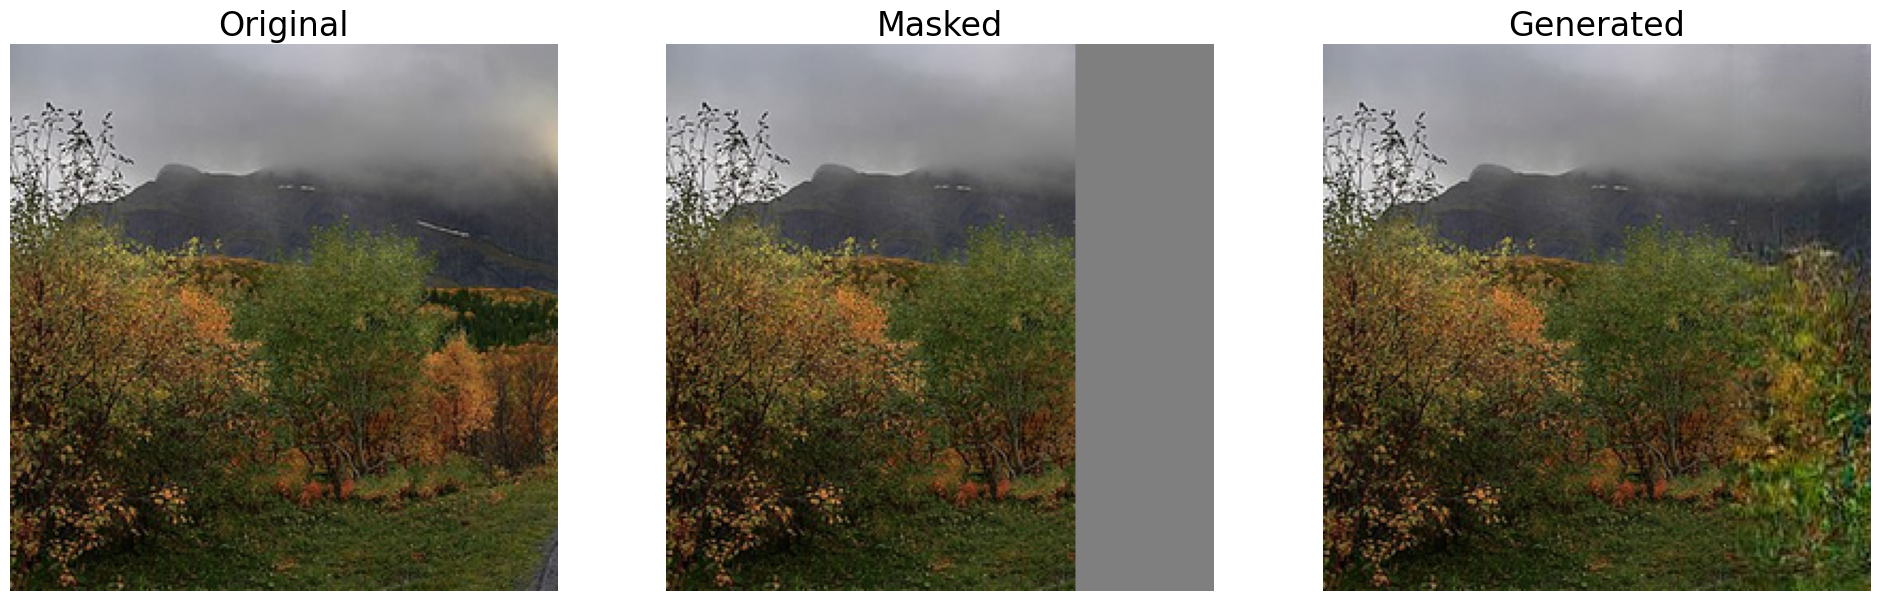

In [8]:
result = model.signatures['default'](tf.constant(input_img))
generated_image =  result['default']
masked_image = result['masked_image']

visualize_output_comparison(input_img, masked_image, generated_image)